<a href="https://colab.research.google.com/github/t4n15hq/dap2/blob/main/dap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

In [2]:
# Load the data
orders_df = pd.read_csv('data/olist_orders.csv')

# Display the first few rows and data info
print(orders_df.head())
print(orders_df.info())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

In [3]:
# Convert date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_columns:
    orders_df[col] = pd.to_datetime(orders_df[col])

# Remove orders with missing delivery dates
orders_df = orders_df.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])

# Calculate the difference between estimated and actual delivery dates
orders_df['delivery_difference'] = (orders_df['order_delivered_customer_date'] - orders_df['order_estimated_delivery_date']).dt.total_seconds() / (24 * 60 * 60)

# Create a category for on-time, early, or late delivery
orders_df['delivery_status'] = pd.cut(orders_df['delivery_difference'],
                                      bins=[-np.inf, -1, 1, np.inf],
                                      labels=['Early', 'On Time', 'Late'])

<ipython-input-3-1329ffc3085b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_df['delivery_difference'] = (orders_df['order_delivered_customer_date'] - orders_df['order_estimated_delivery_date']).dt.total_seconds() / (24 * 60 * 60)
<ipython-input-3-1329ffc3085b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_df['delivery_status'] = pd.cut(orders_df['delivery_difference'],


In [4]:
  # Calculate accuracy metrics
total_orders = len(orders_df)
on_time_orders = len(orders_df[orders_df['delivery_status'] == 'On Time'])
early_orders = len(orders_df[orders_df['delivery_status'] == 'Early'])
late_orders = len(orders_df[orders_df['delivery_status'] == 'Late'])

accuracy = (on_time_orders + early_orders) / total_orders

print(f"Total orders: {total_orders}")
print(f"On-time deliveries: {on_time_orders} ({on_time_orders/total_orders:.2%})")
print(f"Early deliveries: {early_orders} ({early_orders/total_orders:.2%})")
print(f"Late deliveries: {late_orders} ({late_orders/total_orders:.2%})")
print(f"Overall accuracy (on-time or early): {accuracy:.2%}")

Total orders: 96476
On-time deliveries: 2754 (2.85%)
Early deliveries: 87187 (90.37%)
Late deliveries: 6535 (6.77%)
Overall accuracy (on-time or early): 93.23%


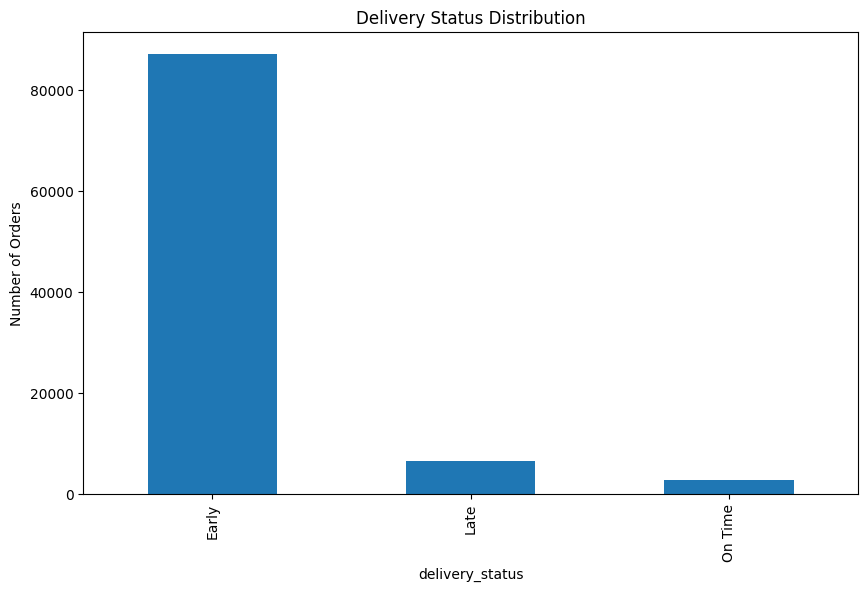

In [5]:
# Visualize delivery status distribution
plt.figure(figsize=(10, 6))
orders_df['delivery_status'].value_counts().plot(kind='bar')
plt.title('Delivery Status Distribution')
plt.ylabel('Number of Orders')
plt.show()

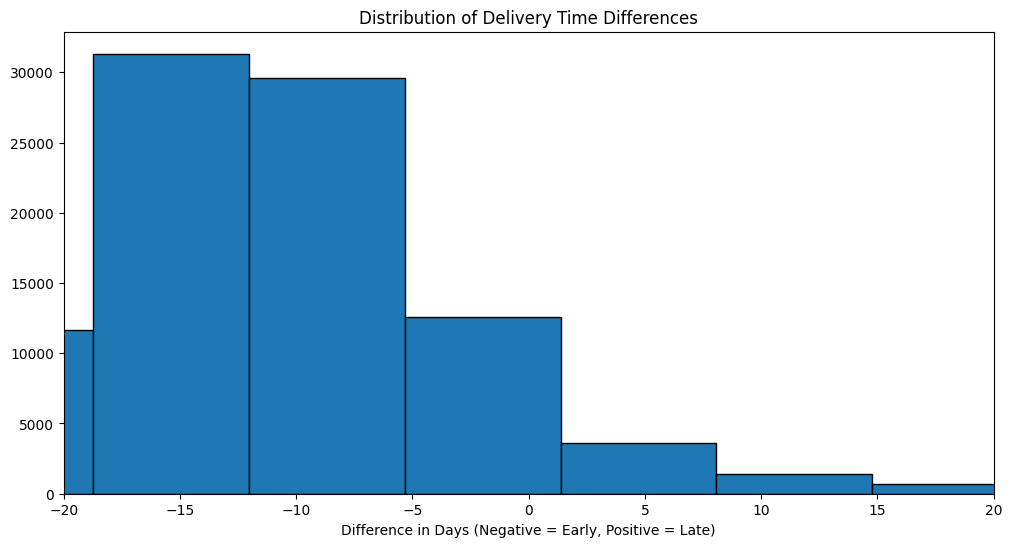

In [6]:
# Visualize delivery difference distribution
plt.figure(figsize=(12, 6))
plt.hist(orders_df['delivery_difference'], bins=50, edgecolor='black')
plt.title('Distribution of Delivery Time Differences')
plt.xlabel('Difference in Days (Negative = Early, Positive = Late)')
plt.xlim(-20, 20)  # Adjust this range as needed
plt.show()

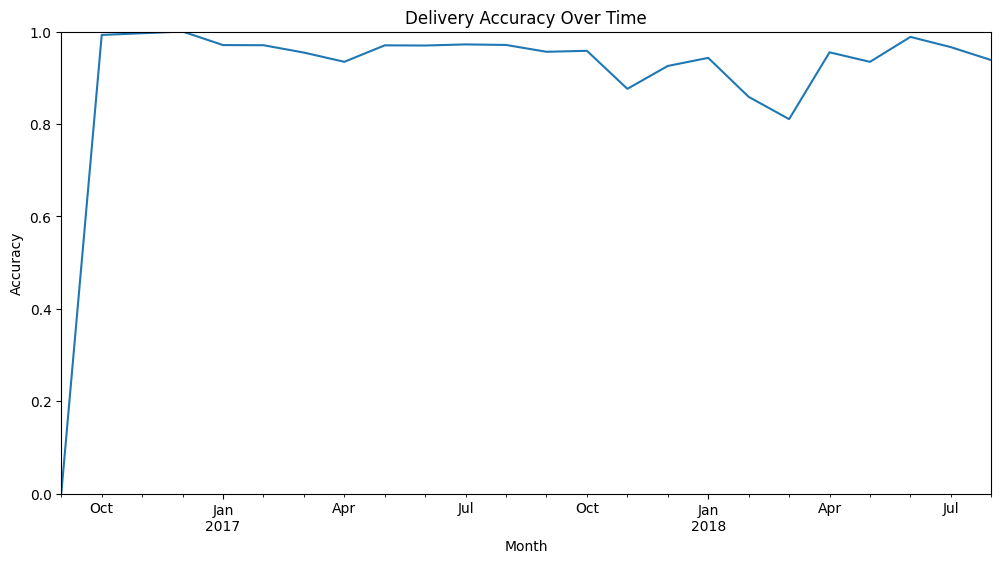

In [7]:
# Analyze accuracy over time
orders_df['order_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')
monthly_accuracy = orders_df.groupby('order_month').apply(lambda x: ((x['delivery_status'] == 'On Time') | (x['delivery_status'] == 'Early')).mean())

plt.figure(figsize=(12, 6))
monthly_accuracy.plot()
plt.title('Delivery Accuracy Over Time')
plt.xlabel('Month')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [8]:
# Summary statistics
print("\nSummary Statistics for Delivery Difference (in days):")
print(orders_df['delivery_difference'].describe())

# Conclusion
print("\nConclusion:")
print(f"The overall accuracy of estimated delivery dates is {accuracy:.2%}.")
print(f"On average, orders are delivered {orders_df['delivery_difference'].mean():.2f} days {'later' if orders_df['delivery_difference'].mean() > 0 else 'earlier'} than estimated.")
print("Further investigation into factors causing delays or early deliveries may be warranted.")


Summary Statistics for Delivery Difference (in days):
count    96476.000000
mean       -11.179120
std         10.186113
min       -146.016123
25%        -16.244384
50%        -11.948941
75%         -6.390000
max        188.975081
Name: delivery_difference, dtype: float64

Conclusion:
The overall accuracy of estimated delivery dates is 93.23%.
On average, orders are delivered -11.18 days earlier than estimated.
Further investigation into factors causing delays or early deliveries may be warranted.
